## 1. Setup

In [6]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import random
import numpy as np
import torch
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if device.type == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cuda
GPU: Tesla T4


## 2. Load Data

In [7]:
from src.data import load_and_prepare_data

train_loader, val_loader, test_loader, src_vocab, trg_vocab = load_and_prepare_data()

print(f'Source vocabulary size: {len(src_vocab)}')
print(f'Target vocabulary size: {len(trg_vocab)}')
print(f'Training batches: {len(train_loader)}')
print(f'Validation batches: {len(val_loader)}')
print(f'Test batches: {len(test_loader)}')

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'Nan-Do/code-search-net-python' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
ERROR:datasets.load:`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'Nan-Do/code-search-net-python' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Loading dataset from Hugging Face...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-ee77a7de79eb2a(…):   0%|          | 0.00/155M [00:00<?, ?B/s]

data/train-00001-of-00004-648b3bede2edf6(…):   0%|          | 0.00/139M [00:00<?, ?B/s]

data/train-00002-of-00004-1dfd72b171e6b2(…):   0%|          | 0.00/153M [00:00<?, ?B/s]

data/train-00003-of-00004-184ab6d0e3c690(…):   0%|          | 0.00/151M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/455243 [00:00<?, ? examples/s]

Dataset columns: ['repo', 'path', 'func_name', 'original_string', 'language', 'code', 'code_tokens', 'docstring', 'docstring_tokens', 'sha', 'url', 'partition', 'summary']
Loaded 13000 valid docstring-code pairs
Tokenizing...
Train: 10000, Val: 1500, Test: 1500
Building vocabularies...
Source vocab size: 12660
Target vocab size: 41897
Source vocabulary size: 12660
Target vocabulary size: 41897
Training batches: 157
Validation batches: 24
Test batches: 24


## 3. Build Model

In [8]:
from src.models import build_lstm

model = build_lstm(len(src_vocab), len(trg_vocab), device)
print(model)
print(f'\nTrainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

LSTMSeq2Seq(
  (encoder): LSTMEncoder(
    (embedding): Embedding(12660, 256, padding_idx=0)
    (lstm): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.3)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): LSTMDecoder(
    (embedding): Embedding(41897, 256, padding_idx=0)
    (lstm): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.3)
    (fc_out): Linear(in_features=256, out_features=41897, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

Trainable parameters: 26,839,465


## 4. Training

In [9]:
from src.train_utils import train_model

history = train_model(
    model, train_loader, val_loader, device,
    model_name='LSTM',
    has_attention=False
)


Training LSTM
Trainable parameters: 26,839,465

Epoch 01/15 | Time: 256.3s | Train Loss: 5.9163 | Val Loss: 5.0245 | Train Acc: 0.1354 | Val Acc: 0.1701 *
Epoch 02/15 | Time: 255.5s | Train Loss: 5.3829 | Val Loss: 5.1189 | Train Acc: 0.1644 | Val Acc: 0.1260
Epoch 03/15 | Time: 255.6s | Train Loss: 5.1336 | Val Loss: 5.0012 | Train Acc: 0.2058 | Val Acc: 0.1617 *
Epoch 04/15 | Time: 255.2s | Train Loss: 4.8616 | Val Loss: 5.0817 | Train Acc: 0.2447 | Val Acc: 0.1533
Epoch 05/15 | Time: 255.4s | Train Loss: 4.6812 | Val Loss: 5.0616 | Train Acc: 0.2686 | Val Acc: 0.1576
Epoch 06/15 | Time: 255.0s | Train Loss: 4.5524 | Val Loss: 5.1372 | Train Acc: 0.2818 | Val Acc: 0.1530
Epoch 07/15 | Time: 254.8s | Train Loss: 4.4405 | Val Loss: 5.1398 | Train Acc: 0.2955 | Val Acc: 0.1605
Epoch 08/15 | Time: 254.3s | Train Loss: 4.3516 | Val Loss: 5.1651 | Train Acc: 0.3052 | Val Acc: 0.1678
Epoch 09/15 | Time: 254.4s | Train Loss: 4.2731 | Val Loss: 5.2084 | Train Acc: 0.3137 | Val Acc: 0.1663
Ep

## 5. Training Curves

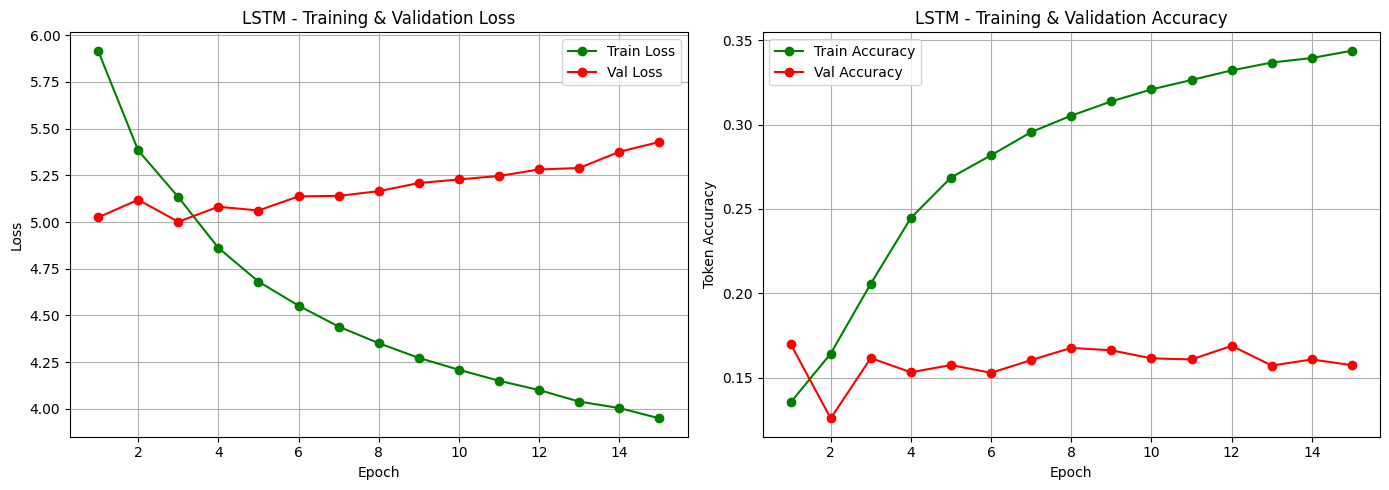

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(history['train_losses']) + 1)

axes[0].plot(epochs, history['train_losses'], 'g-o', label='Train Loss')
axes[0].plot(epochs, history['val_losses'], 'r-o', label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('LSTM - Training & Validation Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(epochs, history['train_accs'], 'g-o', label='Train Accuracy')
axes[1].plot(epochs, history['val_accs'], 'r-o', label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Token Accuracy')
axes[1].set_title('LSTM - Training & Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 6. Test Evaluation

In [11]:
from src.eval_utils import evaluate_model_on_test
from src.config import CHECKPOINT_DIR

checkpoint = torch.load(
    os.path.join(CHECKPOINT_DIR, 'LSTM_best.pt'),
    map_location=device, weights_only=False
)
model.load_state_dict(checkpoint['model_state_dict'])

results = evaluate_model_on_test(model, test_loader, trg_vocab, device, has_attention=False)

print(f"BLEU Score:         {results['avg_bleu']:.4f}")
print(f"Token Accuracy:     {results['token_accuracy']:.4f}")
print(f"Exact Match Rate:   {results['exact_match_rate']:.4f}")
print(f"Examples evaluated: {results['num_examples']}")

BLEU Score:         0.1035
Token Accuracy:     0.1430
Exact Match Rate:   0.0000
Examples evaluated: 1500


## 7. Sample Predictions

In [12]:
for i, sample in enumerate(results['samples'][:5]):
    print(f"\n{'='*60}")
    print(f"Example {i+1}")
    print(f"{'='*60}")
    print(f"Reference:  {sample['reference'][:150]}")
    print(f"Generated:  {sample['generated'][:150]}")
    print(f"BLEU:       {sample['bleu']:.4f}")
    print(f"Exact Match: {sample['exact_match']}")


Example 1
Reference:  def <UNK> ( ) : NEWLINE ' ' ' NEWLINE # <UNK> todo <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UN
Generated:  def <UNK> ( self , : NEWLINE " " " " " " " " " " " " " " NEWLINE NEWLINE . NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE NEWLINE . NEWLINE (
BLEU:       0.0392
Exact Match: False

Example 2
Reference:  def <UNK> ( ) : NEWLINE ' ' ' NEWLINE <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> NEWLINE <UNK> <UNK> M <UNK> <UNK> <UNK> <UNK> <UNK> NEWLIN
Generated:  def <UNK> ( self , : NEWLINE " " " " NEWLINE NEWLINE the the the the the the the the the the the the the the the the the the the NEWLINE NEWLINE NEWLI
BLEU:       0.0333
Exact Match: False

Example 3
Reference:  def <UNK> ( ip = None , port = None ) : NEWLINE " " " <UNK> <UNK> <UNK> <UNK> NEWLINE NEWLINE Keyword Arguments : NEWLINE ip { [ type ] } - - [ descri
Generated:  def <UNK> ( self , : NEWLINE " " " " NEWLINE NEWLINE the the the

## 8. Error Analysis

In [13]:
from src.eval_utils import analyze_errors

errors = analyze_errors(results['samples'])
print('Error Analysis:')
for error_type, count in errors.items():
    print(f'  {error_type:25s}: {count}')

Error Analysis:
  syntax_errors            : 10
  missing_indentation      : 0
  incorrect_operators      : 8
  missing_tokens           : 0
  extra_tokens             : 10
  total_errors             : 10


## 9. BLEU Score vs Docstring Length

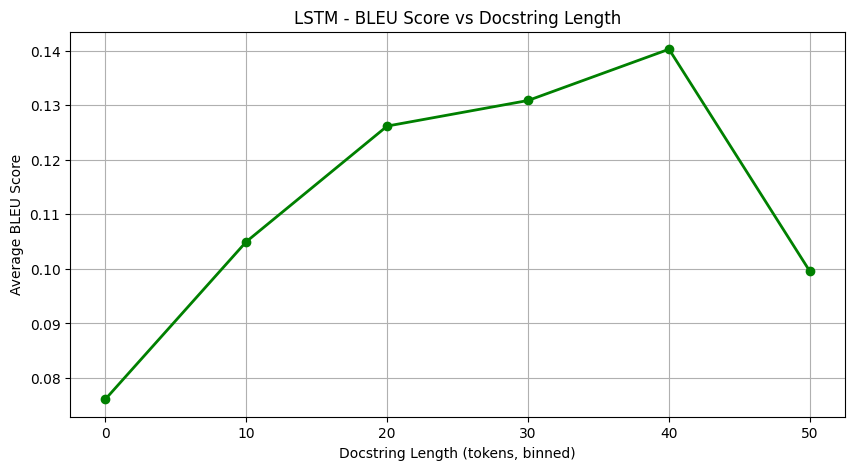

In [14]:
from src.eval_utils import bleu_vs_docstring_length

length_bleu = bleu_vs_docstring_length(model, test_loader, src_vocab, trg_vocab, device, has_attention=False)

plt.figure(figsize=(10, 5))
bins = sorted(length_bleu.keys())
scores = [length_bleu[b] for b in bins]
plt.plot(bins, scores, 'g-o', linewidth=2)
plt.xlabel('Docstring Length (tokens, binned)')
plt.ylabel('Average BLEU Score')
plt.title('LSTM - BLEU Score vs Docstring Length')
plt.grid(True)
plt.show()